In [1]:
import librosa
import numpy as np
import pandas as pd
from tqdm import tqdm
from os.path import join
from os import listdir
import tensorflow as tf
from keras.layers import Dense
import matplotlib.pyplot as plt
from keras.models import Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import Callback
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.initializers import RandomUniform
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
class EarlyStopper(Callback):
    """
    A class for early stopper callback for validation accuracy
    """
    def __init__(self, target):
        super(EarlyStopper, self).__init__()
        self.target = target

    def on_epoch_end(self, epoch, logs={}):
        val_loss = logs['val_loss']
        if val_loss < self.target:
            self.model.stop_training = True

In [3]:
def create_dnn(in_shape):
    model_name = "DNN"
    model = Sequential()
    model.add(Dense(32, activation="relu", input_shape=in_shape))
    model.add(Dense(64, activation="relu", input_shape=in_shape))
    model.add(Dense(128,
                    kernel_initializer=RandomUniform(minval=-0.05, maxval=0.05),
                    kernel_regularizer=l2(0.001),
                    activation="relu"))
    model.add(Dense(256,
                    kernel_initializer=RandomUniform(minval=-0.05, maxval=0.05),
                    kernel_regularizer=l2(0.001),
                    activation="relu"))
    model.add(Dense(512,
                    kernel_initializer=RandomUniform(minval=-0.05, maxval=0.05),
                    kernel_regularizer=l2(0.001),
                    activation="relu"))
    model.add(Dense(256, activation="relu", kernel_regularizer=l2(0.001)))
    model.add(Dense(128, activation="relu", kernel_regularizer=l2(0.001)))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(Dense(64, activation="relu", kernel_regularizer=l2(0.001)))
    model.add(Dense(2,
                    kernel_initializer=RandomUniform(minval=-0.05, maxval=0.05),
                    kernel_regularizer=l2(0.001),
                    activation="softmax"))

    model.compile(optimizer="Adam", 
                  loss="sparse_categorical_crossentropy", 
                  metrics=["accuracy"])
    return model, model_name

In [4]:
def create_dnn_mini(in_shape):
    model_name = "DNN_MINI"
    model = Sequential()
    model.add(Dense(32,
                    kernel_initializer=RandomUniform(minval=-0.05, maxval=0.05),
                    kernel_regularizer=l2(0.001),
                    activation="relu"))
    model.add(Dense(128,
                    kernel_initializer=RandomUniform(minval=-0.05, maxval=0.05),
                    kernel_regularizer=l2(0.001),
                    activation="relu"))
    model.add(Dense(64, activation="relu", kernel_regularizer=l2(0.001)))
    model.add(Dense(2,
                    kernel_initializer=RandomUniform(minval=-0.05, maxval=0.05),
                    kernel_regularizer=l2(0.001),
                    activation="softmax"))

    model.compile(optimizer="Adam", 
                  loss="sparse_categorical_crossentropy", 
                  metrics=["accuracy"])
    return model, model_name

In [5]:
def create_cnn(in_shape):
    model_name = "CNN"
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
              activation='relu',
              input_shape=(in_shape[0],
              in_shape[1], 1)))

    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(Flatten())
    model.add(Dense(64, kernel_initializer=RandomUniform(minval=-0.05,
                    maxval=0.05), kernel_regularizer=l2(0.001),
                    activation='relu'))
    model.add(Dense(2, kernel_initializer=RandomUniform(minval=-0.05,
                    maxval=0.05), kernel_regularizer=l2(0.001),
                    activation='softmax'))
    model.compile(optimizer='Adam',
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])
    return model, model_name

In [6]:
def plot_history(history):
    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])
    plt.xlabel("Epochs")
    plt.ylabel("log Loss")
    plt.legend(["train", "validation"], loc="upper right")
    plt.show()

In [7]:
RECORDING_DIR = "/kaggle/input/rainfall-mini-dataset/rain_dataset"
CLASSES = ["rain", "ambient"]
MODELS = ["DNN", "CNN"]
EPOCHS = 60
BATCH_SIZE = 16
SAMPLING_RATEs = [2000, 16000, 48000]
BIT_DEPTHs = [np.uint8, np.uint16, np.float32]
SAMPLE_DURATION = 10
VALIDATION_SPLIT = 0.25
VALIDATION_LOSS_CUTOFF = 0.02
fs_mapper = {2000:40,
            16000:313,
            48000:938}

In [8]:
file_names = []
target = []

for label in CLASSES:
    fnames = listdir(join(RECORDING_DIR, label))
    num_samples = len(fnames)
    file_names.extend(fnames)
    target.extend([label] * num_samples)

In [9]:
result_df = pd.DataFrame()
basic_data = pd.DataFrame()
basic_data["filename"] = file_names
basic_data["class"] = target
basic_data["target"] = basic_data["class"].replace({"ambient": 0, "rain": 1})

In [10]:
def create_dnn_data(basic_data, Fs, bit_depth):
    spectrum_data = np.empty((0, Fs * SAMPLE_DURATION), float)
    for index, row in basic_data.iterrows():
        file_path = join(RECORDING_DIR, row["class"], row["filename"])
        x, Fs = librosa.load(file_path, sr=Fs)
        x = x.astype(bit_depth)
        depth = x.dtype
        xfft = np.abs(np.fft.fft(x))
        spectrum_data = np.vstack([spectrum_data, xfft])
    return spectrum_data, depth

In [11]:
def create_cnn_data(basic_data, Fs, bit_depth, fs_mapper):
    n_samples = basic_data.shape[0]
    dim = fs_mapper[Fs]
    stft_data = np.empty(shape=[0, 1025, dim])
    for index, row in basic_data.iterrows():
        file_path = join(RECORDING_DIR, row["class"], row["filename"])
        x, Fs = librosa.load(file_path, sr=Fs)
        x = x.astype(bit_depth)
        depth = x.dtype
        x = x.astype(np.float32)
        stft_sample = np.abs(librosa.stft(x))
        stft_data = np.vstack([stft_data, stft_sample[np.newaxis,...]])
    return stft_data, depth

  0%|          | 0/3 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.7142 - accuracy: 0.3333
   EPOCHS  Sampling_Rate Bit_Depth Model Test_Accuracy  Test_Loss
0      60           2000     uint8   DNN       33.33%    0.714173


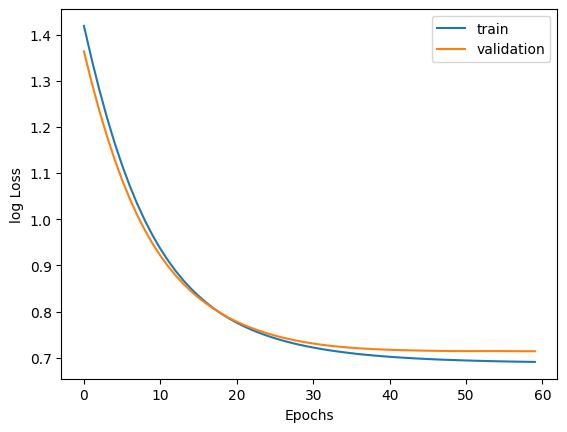

1/1 [==============================] - 0s 25ms/step - loss: 0.7110 - accuracy: 0.3333
   EPOCHS  Sampling_Rate Bit_Depth Model Test_Accuracy  Test_Loss
0      60           2000     uint8   DNN       33.33%    0.714173
1      60           2000     uint8   CNN       33.33%    0.711034


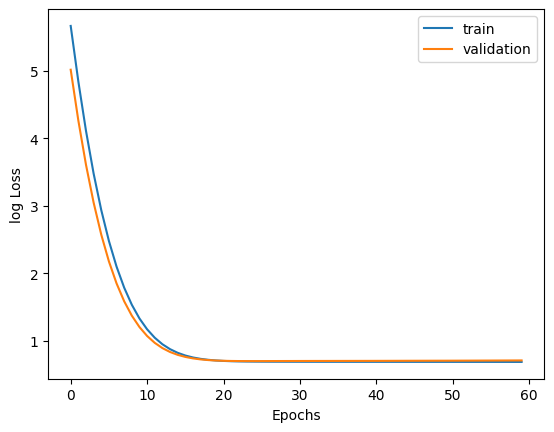

1/1 [==============================] - 0s 23ms/step - loss: 0.7115 - accuracy: 0.3333
   EPOCHS  Sampling_Rate Bit_Depth Model Test_Accuracy  Test_Loss
0      60           2000     uint8   DNN       33.33%    0.714173
1      60           2000     uint8   CNN       33.33%    0.711034
2      60           2000    uint16   DNN       33.33%    0.711474


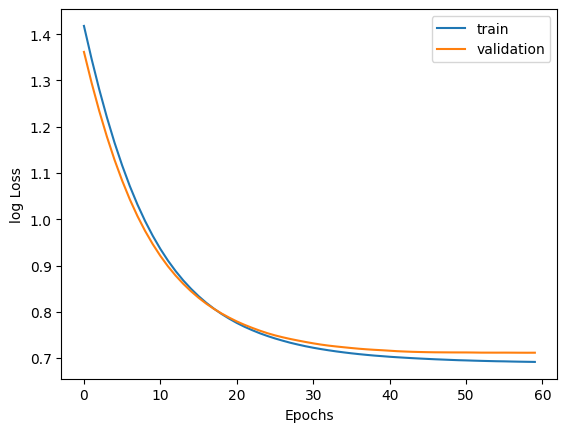

1/1 [==============================] - 0s 24ms/step - loss: 0.7124 - accuracy: 0.3333
   EPOCHS  Sampling_Rate Bit_Depth Model Test_Accuracy  Test_Loss
0      60           2000     uint8   DNN       33.33%    0.714173
1      60           2000     uint8   CNN       33.33%    0.711034
2      60           2000    uint16   DNN       33.33%    0.711474
3      60           2000    uint16   CNN       33.33%    0.712375


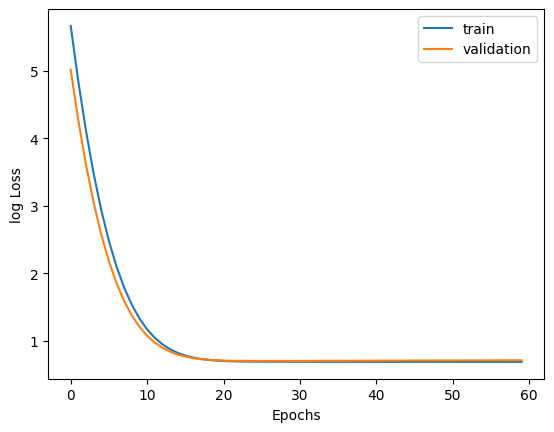

1/1 [==============================] - 0s 22ms/step - loss: 0.1456 - accuracy: 1.0000
   EPOCHS  Sampling_Rate Bit_Depth Model Test_Accuracy  Test_Loss
0      60           2000     uint8   DNN       33.33%    0.714173
1      60           2000     uint8   CNN       33.33%    0.711034
2      60           2000    uint16   DNN       33.33%    0.711474
3      60           2000    uint16   CNN       33.33%    0.712375
4      60           2000   float32   DNN      100.00%    0.145618


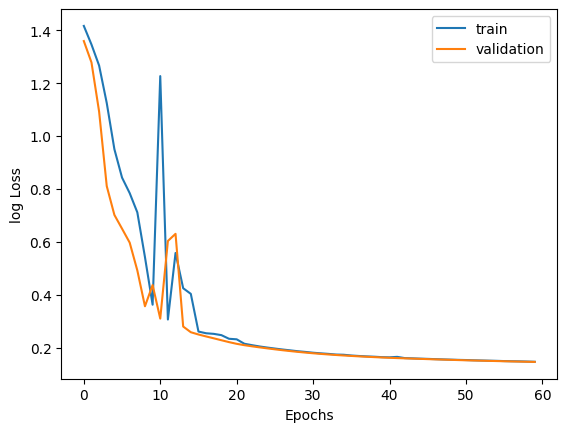

1/1 [==============================] - 0s 26ms/step - loss: 0.0316 - accuracy: 1.0000
   EPOCHS  Sampling_Rate Bit_Depth Model Test_Accuracy  Test_Loss
0      60           2000     uint8   DNN       33.33%    0.714173
1      60           2000     uint8   CNN       33.33%    0.711034
2      60           2000    uint16   DNN       33.33%    0.711474
3      60           2000    uint16   CNN       33.33%    0.712375
4      60           2000   float32   DNN      100.00%    0.145618
5      60           2000   float32   CNN      100.00%    0.031594


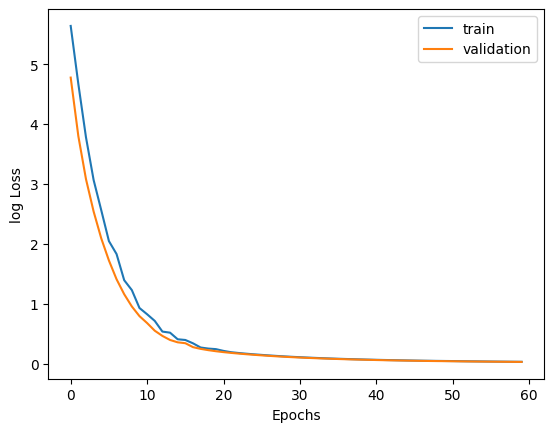

 33%|███▎      | 1/3 [01:50<03:40, 110.33s/it]

1/1 [==============================] - 0s 30ms/step - loss: 0.7097 - accuracy: 0.3333
   EPOCHS  Sampling_Rate Bit_Depth Model Test_Accuracy  Test_Loss
0      60           2000     uint8   DNN       33.33%    0.714173
1      60           2000     uint8   CNN       33.33%    0.711034
2      60           2000    uint16   DNN       33.33%    0.711474
3      60           2000    uint16   CNN       33.33%    0.712375
4      60           2000   float32   DNN      100.00%    0.145618
5      60           2000   float32   CNN      100.00%    0.031594
6      60          16000     uint8   DNN       33.33%    0.709711


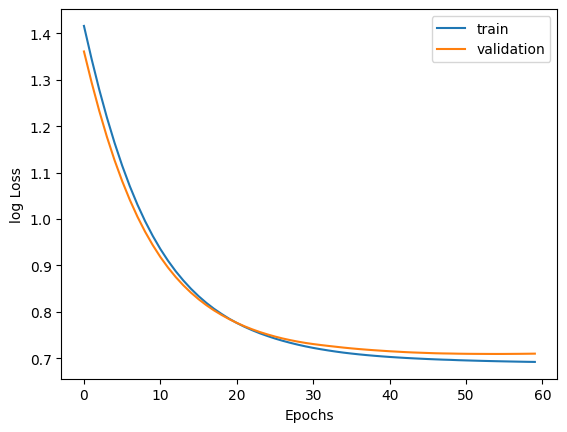

1/1 [==============================] - 0s 43ms/step - loss: 0.7093 - accuracy: 0.3333
   EPOCHS  Sampling_Rate Bit_Depth Model Test_Accuracy  Test_Loss
0      60           2000     uint8   DNN       33.33%    0.714173
1      60           2000     uint8   CNN       33.33%    0.711034
2      60           2000    uint16   DNN       33.33%    0.711474
3      60           2000    uint16   CNN       33.33%    0.712375
4      60           2000   float32   DNN      100.00%    0.145618
5      60           2000   float32   CNN      100.00%    0.031594
6      60          16000     uint8   DNN       33.33%    0.709711
7      60          16000     uint8   CNN       33.33%    0.709288


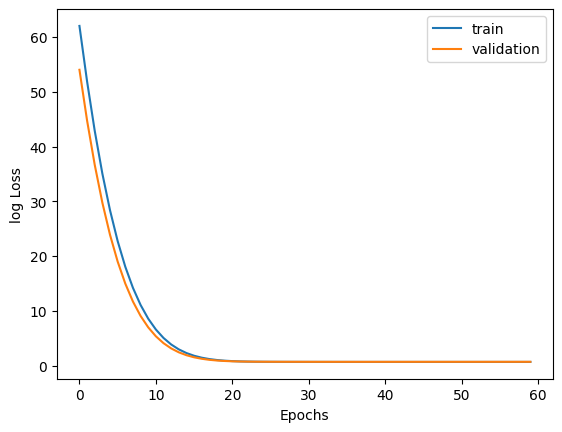

1/1 [==============================] - 0s 31ms/step - loss: 0.7094 - accuracy: 0.3333
   EPOCHS  Sampling_Rate Bit_Depth Model Test_Accuracy  Test_Loss
0      60           2000     uint8   DNN       33.33%    0.714173
1      60           2000     uint8   CNN       33.33%    0.711034
2      60           2000    uint16   DNN       33.33%    0.711474
3      60           2000    uint16   CNN       33.33%    0.712375
4      60           2000   float32   DNN      100.00%    0.145618
5      60           2000   float32   CNN      100.00%    0.031594
6      60          16000     uint8   DNN       33.33%    0.709711
7      60          16000     uint8   CNN       33.33%    0.709288
8      60          16000    uint16   DNN       33.33%    0.709432


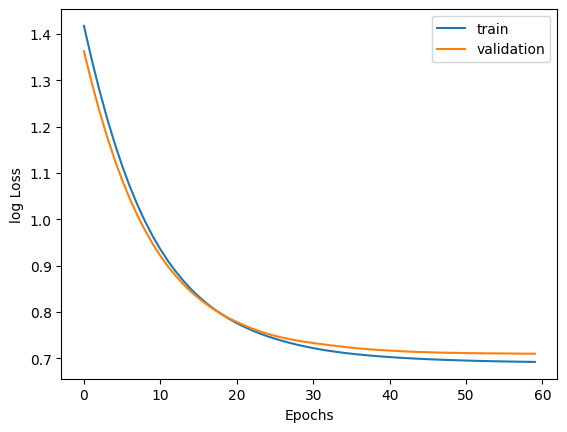

1/1 [==============================] - 0s 43ms/step - loss: 0.7135 - accuracy: 0.3333
   EPOCHS  Sampling_Rate Bit_Depth Model Test_Accuracy  Test_Loss
0      60           2000     uint8   DNN       33.33%    0.714173
1      60           2000     uint8   CNN       33.33%    0.711034
2      60           2000    uint16   DNN       33.33%    0.711474
3      60           2000    uint16   CNN       33.33%    0.712375
4      60           2000   float32   DNN      100.00%    0.145618
5      60           2000   float32   CNN      100.00%    0.031594
6      60          16000     uint8   DNN       33.33%    0.709711
7      60          16000     uint8   CNN       33.33%    0.709288
8      60          16000    uint16   DNN       33.33%    0.709432
9      60          16000    uint16   CNN       33.33%    0.713460


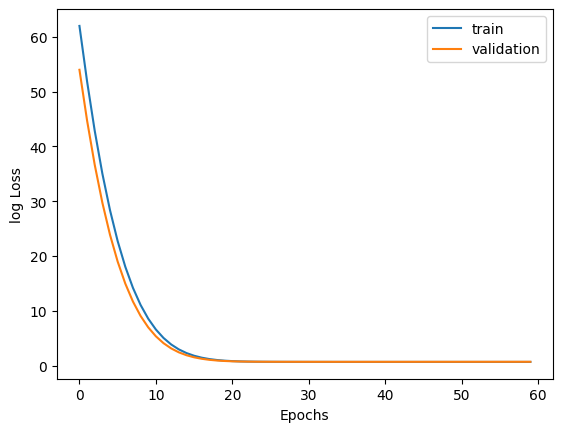

1/1 [==============================] - 0s 28ms/step - loss: 0.0724 - accuracy: 1.0000
    EPOCHS  Sampling_Rate Bit_Depth Model Test_Accuracy  Test_Loss
0       60           2000     uint8   DNN       33.33%    0.714173
1       60           2000     uint8   CNN       33.33%    0.711034
2       60           2000    uint16   DNN       33.33%    0.711474
3       60           2000    uint16   CNN       33.33%    0.712375
4       60           2000   float32   DNN      100.00%    0.145618
5       60           2000   float32   CNN      100.00%    0.031594
6       60          16000     uint8   DNN       33.33%    0.709711
7       60          16000     uint8   CNN       33.33%    0.709288
8       60          16000    uint16   DNN       33.33%    0.709432
9       60          16000    uint16   CNN       33.33%    0.713460
10      60          16000   float32   DNN      100.00%    0.072428


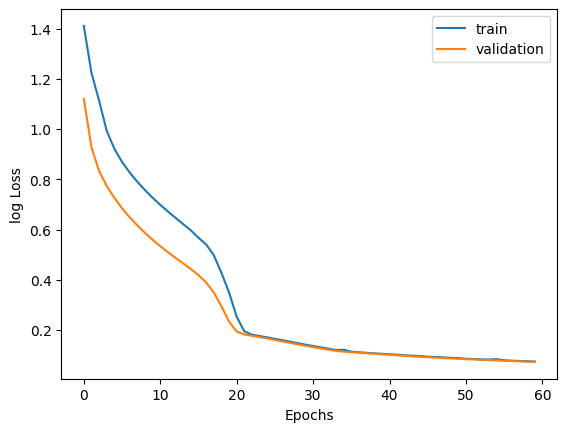

1/1 [==============================] - 0s 43ms/step - loss: 0.4163 - accuracy: 0.9167
    EPOCHS  Sampling_Rate Bit_Depth Model Test_Accuracy  Test_Loss
0       60           2000     uint8   DNN       33.33%    0.714173
1       60           2000     uint8   CNN       33.33%    0.711034
2       60           2000    uint16   DNN       33.33%    0.711474
3       60           2000    uint16   CNN       33.33%    0.712375
4       60           2000   float32   DNN      100.00%    0.145618
5       60           2000   float32   CNN      100.00%    0.031594
6       60          16000     uint8   DNN       33.33%    0.709711
7       60          16000     uint8   CNN       33.33%    0.709288
8       60          16000    uint16   DNN       33.33%    0.709432
9       60          16000    uint16   CNN       33.33%    0.713460
10      60          16000   float32   DNN      100.00%    0.072428
11      60          16000   float32   CNN       91.67%    0.416291


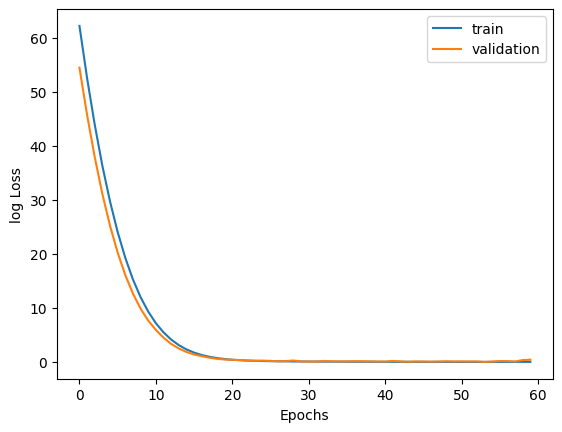

 67%|██████▋   | 2/3 [12:34<07:04, 424.20s/it]

1/1 [==============================] - 0s 36ms/step - loss: 0.7184 - accuracy: 0.3333
    EPOCHS  Sampling_Rate Bit_Depth Model Test_Accuracy  Test_Loss
0       60           2000     uint8   DNN       33.33%    0.714173
1       60           2000     uint8   CNN       33.33%    0.711034
2       60           2000    uint16   DNN       33.33%    0.711474
3       60           2000    uint16   CNN       33.33%    0.712375
4       60           2000   float32   DNN      100.00%    0.145618
5       60           2000   float32   CNN      100.00%    0.031594
6       60          16000     uint8   DNN       33.33%    0.709711
7       60          16000     uint8   CNN       33.33%    0.709288
8       60          16000    uint16   DNN       33.33%    0.709432
9       60          16000    uint16   CNN       33.33%    0.713460
10      60          16000   float32   DNN      100.00%    0.072428
11      60          16000   float32   CNN       91.67%    0.416291
12      60          48000     uint8   DNN  

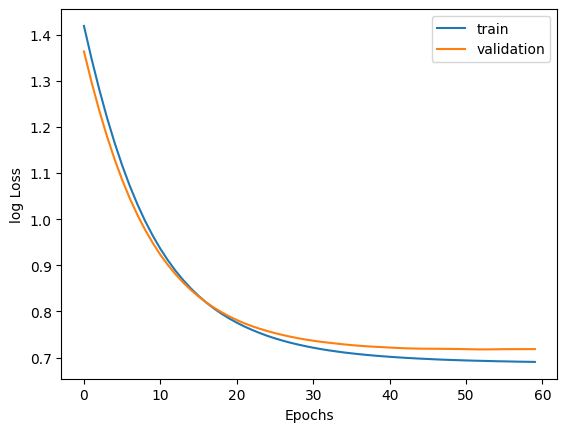

1/1 [==============================] - 0s 111ms/step - loss: 0.7129 - accuracy: 0.3333
    EPOCHS  Sampling_Rate Bit_Depth Model Test_Accuracy  Test_Loss
0       60           2000     uint8   DNN       33.33%    0.714173
1       60           2000     uint8   CNN       33.33%    0.711034
2       60           2000    uint16   DNN       33.33%    0.711474
3       60           2000    uint16   CNN       33.33%    0.712375
4       60           2000   float32   DNN      100.00%    0.145618
5       60           2000   float32   CNN      100.00%    0.031594
6       60          16000     uint8   DNN       33.33%    0.709711
7       60          16000     uint8   CNN       33.33%    0.709288
8       60          16000    uint16   DNN       33.33%    0.709432
9       60          16000    uint16   CNN       33.33%    0.713460
10      60          16000   float32   DNN      100.00%    0.072428
11      60          16000   float32   CNN       91.67%    0.416291
12      60          48000     uint8   DNN 

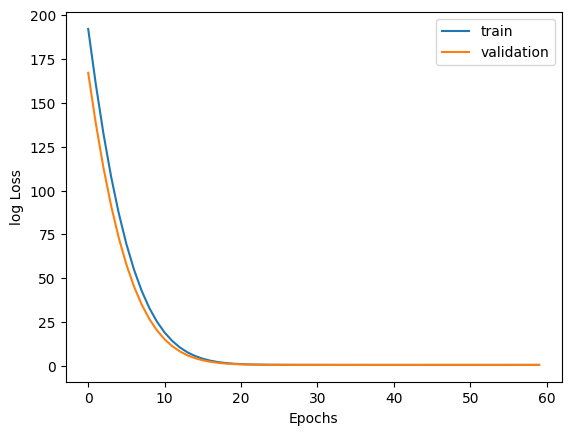

1/1 [==============================] - 0s 38ms/step - loss: 0.7144 - accuracy: 0.3333
    EPOCHS  Sampling_Rate Bit_Depth Model Test_Accuracy  Test_Loss
0       60           2000     uint8   DNN       33.33%    0.714173
1       60           2000     uint8   CNN       33.33%    0.711034
2       60           2000    uint16   DNN       33.33%    0.711474
3       60           2000    uint16   CNN       33.33%    0.712375
4       60           2000   float32   DNN      100.00%    0.145618
5       60           2000   float32   CNN      100.00%    0.031594
6       60          16000     uint8   DNN       33.33%    0.709711
7       60          16000     uint8   CNN       33.33%    0.709288
8       60          16000    uint16   DNN       33.33%    0.709432
9       60          16000    uint16   CNN       33.33%    0.713460
10      60          16000   float32   DNN      100.00%    0.072428
11      60          16000   float32   CNN       91.67%    0.416291
12      60          48000     uint8   DNN  

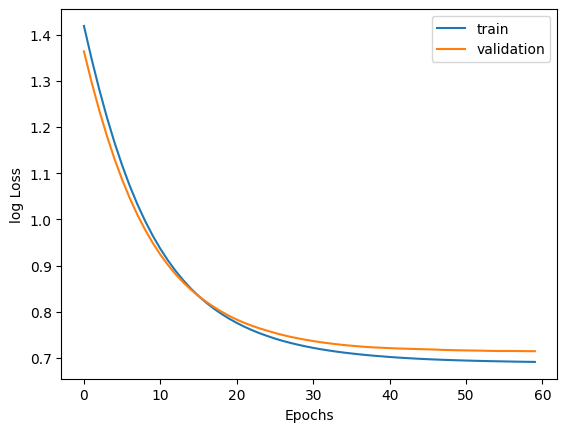

In [ ]:
i=0
for fs in tqdm(SAMPLING_RATEs):
    for bit_depth in BIT_DEPTHs:
        for model_type in MODELS:
            if model_type=="CNN":
                spectrum_data, depth = create_cnn_data(basic_data, fs, bit_depth, fs_mapper)
            else:
                spectrum_data, depth = create_dnn_data(basic_data, fs, bit_depth)
            
            X_train, X_test, y_train, y_test = train_test_split(spectrum_data,
                                                                basic_data["target"],
                                                                test_size=VALIDATION_SPLIT,
                                                                random_state=2)
            if model_type=="CNN": 
                model, model_name = create_cnn(X_train[0].shape)
            else:
                model, model_name = create_dnn(X_train[0].shape)
        
            cp_callback = ModelCheckpoint(filepath="./model/dnn.hdf5",
                                          monitor="val_loss",
                                          verbose=0,
                                          save_best_only=True,
                                          mode="min")
        #     early_stopper_cb = EarlyStopper(VALIDATION_LOSS_CUTOFF)
            history = model.fit(X_train,
                            y_train,
                            batch_size=BATCH_SIZE,
                            epochs=EPOCHS,
                            validation_data=(X_test, y_test),
                            callbacks=[cp_callback],
                            verbose=0)
            test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
            row_df = pd.DataFrame({"EPOCHS": EPOCHS,
                                   "Sampling_Rate":fs,
                                   "Bit_Depth":depth,
                                   "Model":model_name,
                                   "Test_Accuracy":"{:5.2f}% ".format(100 * test_accuracy),
                                   "Test_Loss":test_loss}, index=[i])

            result_df = pd.concat([result_df, row_df])
            print(result_df)
            plot_history(history)
            i+=1

In [ ]:
result_df